# Design Pattern 2 - Embeddings (Chapter 2) - bonus material 

## Using an Autoencoder to learn an embedding for use with anomaly detection

Inspired by examples here:

https://towardsdatascience.com/autoencoders-for-the-compression-of-stock-market-data-28e8c1a2da3e

https://www.pyimagesearch.com/2020/03/02/anomaly-detection-with-keras-tensorflow-and-deep-learning/

The example uses mitbih ecg data from kaggle:

https://www.kaggle.com/shayanfazeli/heartbeat

The ecg readings consist of 5 classes, 'N' is Normal and 'S', 'V', 'F' and 'Q' are abnormal

In the previous embedding notebook we looked at how to set up and train embeddings using Tensorflow in a supervised
learning scenario. 

Autoencoders allow for unsupervised learning of embeddings in a reduced dimension space. Autoencoders learn to reconstruct data inputs 
from a lower-dimensional latent space: the inputs are also used for the outputs!

In this example we want to try and identify anomalous ecg signals. We have a high dimensional dataset and furthermore the ecg signals are of different lengths, so we learn an embedding over the inputs.

We will train the Autoencoder on 'normal' inputs only.

We can then present 'anomalous' data to the trained model and measure the reconstruction error - it should be higher for anomalous signals


#### Imports

In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

from sklearn.model_selection import train_test_split

import s3fs

import random

import io

%matplotlib inline

#### Load the data

In [2]:
s3 = s3fs.S3FileSystem()

data_url = 's3://sam-ml-test-datasets/ecg_data/mitbih_train.csv'

train_data = pd.read_csv(data_url, header=None)

print('Train data dimensions: rows ', train_data.shape[0], ', columns ', train_data.shape[1])
print(train_data.head(5))

Train data dimensions: rows  87554 , columns  188
        0         1         2         3         4         5         6    \
0  0.977941  0.926471  0.681373  0.245098  0.154412  0.191176  0.151961   
1  0.960114  0.863248  0.461538  0.196581  0.094017  0.125356  0.099715   
2  1.000000  0.659459  0.186486  0.070270  0.070270  0.059459  0.056757   
3  0.925414  0.665746  0.541436  0.276243  0.196133  0.077348  0.071823   
4  0.967136  1.000000  0.830986  0.586854  0.356808  0.248826  0.145540   

        7         8         9    ...  178  179  180  181  182  183  184  185  \
0  0.085784  0.058824  0.049020  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.088319  0.074074  0.082621  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.043243  0.054054  0.045946  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.060773  0.066298  0.058011  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.089202  0.117371  0.150235  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   186  187  
0  0

#### Make the column names strings

In [3]:
train_data.columns = ['a'+str(col) for col in train_data.columns]

#### Plot an example of each category

0
72471
1
2223
2
5788
3
641
4
6431


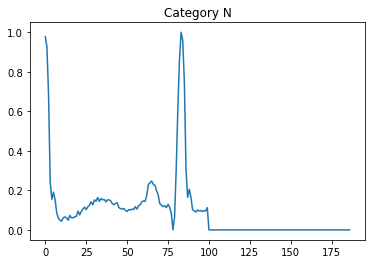

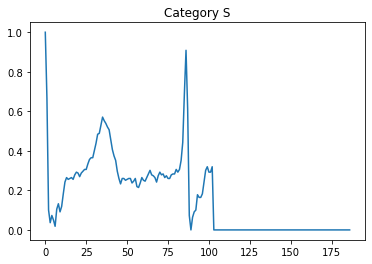

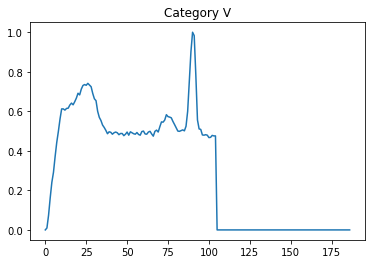

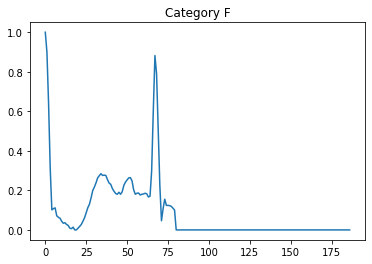

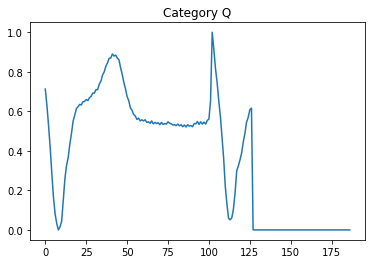

In [4]:
categories = {0.0: 'N', 1.0:'S', 2.0: 'V', 3.0: 'F', 4.0: 'Q'}

for cat in range(0,5):
        print(cat)
        sample = train_data.loc[train_data['a187'] == float(cat)]
        print(len(sample))
        plt.figure()
        plt.plot(sample.values[0,0:187])
        plt.title('Category ' + categories[sample.values[0,187]])

#### Split out valid and anomaly data

In [5]:
# We will train on the normal examples only

valid_data = train_data.loc[train_data['a187'] == 0.0]
print(valid_data['a187'].unique())
valid_data = valid_data.drop(['a187'], axis=1)

# Select one of the abnormal cases to be the anomaly
# Here I'm going for the most anomalous looking case, Q

#anom_data = train_data.loc[train_data['a187'] != 0.0]
anom_data = train_data.loc[train_data['a187'] == 4.0]
print(anom_data['a187'].unique())
anom_data = anom_data.drop(['a187'], axis=1)


[0.]
[4.]


#### Format data ready for Tensorflow

In [6]:
# add a channel dimension and ensure type is float32
valid = np.expand_dims(valid_data.values, axis=-1)
anom = np.expand_dims(anom_data.values, axis=-1)
valid = valid.astype("float32")
anom = anom.astype("float32")

#### Split training data into train and validation sets

In [7]:
(trainX, valX) = train_test_split(valid, test_size=0.2)

#### Set up the Autoencoder model 

In [8]:
input_shape = (valid.shape[1], valid.shape[2])
latentDim = 50
chanDim = -1
EPOCHS = 20
LR = 0.001
BS = 100

# construct the encoder part
input_layer = tf.keras.layers.Input(shape=input_shape, name='input_layer')
x = tf.keras.layers.Conv1D(32, 3, 1,activation="relu", padding="same")(input_layer) 
x = tf.keras.layers.MaxPooling1D(2, padding="same")(x) 
x = tf.keras.layers.Conv1D(16, 3, 1,activation="relu", padding="same")(x)

# flatten the network and then construct our latent vector
volumeSize = K.int_shape(x)
x = tf.keras.layers.Flatten()(x)
latent = tf.keras.layers.Dense(latentDim, name="encoded")(x)

# start building the decoder model which will accept the output of the encoder as its inputs
x = tf.keras.layers.Dense(np.prod(volumeSize[1:]))(latent)
x = tf.keras.layers.Reshape((volumeSize[1], volumeSize[2]))(x)
x = tf.keras.layers.Conv1D(16, 3, 1, padding="same")(x)
x = tf.keras.layers.UpSampling1D(2)(x)
x = tf.keras.layers.Conv1D(32, 3, 1, padding="same")(x)
x = tf.keras.layers.Cropping1D(cropping=(0,1))(x)
decoded = tf.keras.layers.Conv1D(1, 3, activation="sigmoid", padding="same")(x) 

autoencoder = tf.keras.Model(input_layer,decoded)
print(autoencoder.summary())

#opt = tf.keras.optimizers.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

opt = tf.keras.optimizers.Adam(lr=LR)

autoencoder.compile(optimizer=opt, loss='binary_crossentropy')
#autoencoder.compile(optimizer=opt, loss='mse')

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 187, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 187, 32)           128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 94, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 94, 16)            1552      
_________________________________________________________________
flatten (Flatten)            (None, 1504)              0         
_________________________________________________________________
encoded (Dense)              (None, 50)                75250     
_________________________________________________________________
dense (Dense)                (None, 1504)             

#### Train the model

In [9]:
# Are we using the GPU ?
print('Using GPU:', tf.test.gpu_device_name())

H = autoencoder.fit(trainX, trainX,
                epochs=EPOCHS,
                batch_size=BS,
                shuffle=True,
                validation_data=(valX, valX))

Using GPU: /device:GPU:0
Epoch 1/20
580/580 [==============================] - 4s 8ms/step - loss: 0.2966 - val_loss: 0.2771
Epoch 2/20
580/580 [==============================] - 4s 7ms/step - loss: 0.2761 - val_loss: 0.2750
Epoch 3/20
580/580 [==============================] - 4s 7ms/step - loss: 0.2750 - val_loss: 0.2744
Epoch 4/20
580/580 [==============================] - 4s 7ms/step - loss: 0.2745 - val_loss: 0.2741
Epoch 5/20
580/580 [==============================] - 4s 7ms/step - loss: 0.2743 - val_loss: 0.2739
Epoch 6/20
580/580 [==============================] - 4s 7ms/step - loss: 0.2741 - val_loss: 0.2737
Epoch 7/20
580/580 [==============================] - 4s 7ms/step - loss: 0.2739 - val_loss: 0.2736
Epoch 8/20
580/580 [==============================] - 4s 7ms/step - loss: 0.2738 - val_loss: 0.2735
Epoch 9/20
580/580 [==============================] - 4s 7ms/step - loss: 0.2737 - val_loss: 0.2735
Epoch 10/20
580/580 [==============================] - 4s 7ms/step - loss: 

#### Construct a plot of the training history

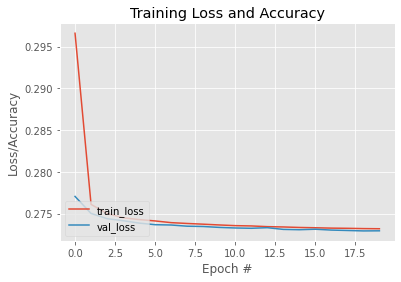

In [10]:
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig('./plots/ae_ecg_loss.png')

#### Save the model

In [11]:
autoencoder.save('./saved_model/ae_ecg')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./saved_model/ae_ecg/assets


#### Testing

#### Plotting function to compare truth with reconstructions

In [12]:
def visualize_predictions(preds, truth, title):
    f, ax = plt.subplots(nrows=preds.shape[0], ncols=1, squeeze=False, sharex=True, figsize=(10,10))
    # loop over our number of output samples
    for i in range(0, preds.shape[0]):
        # grab the original image and reconstructed image
        original = truth[i,:,0]
        recon = preds[i,:,0]
        ax[i][0].plot( original, color="k", alpha=0.5 )
        ax[i][0].plot( recon, color="r" )
    plt.suptitle(title)
    #plt.savefig('./plots/ae_ecg_results.png')

#### Generate reconstructions for training data (normal cases)

In [13]:
train_preds = autoencoder.predict(trainX)

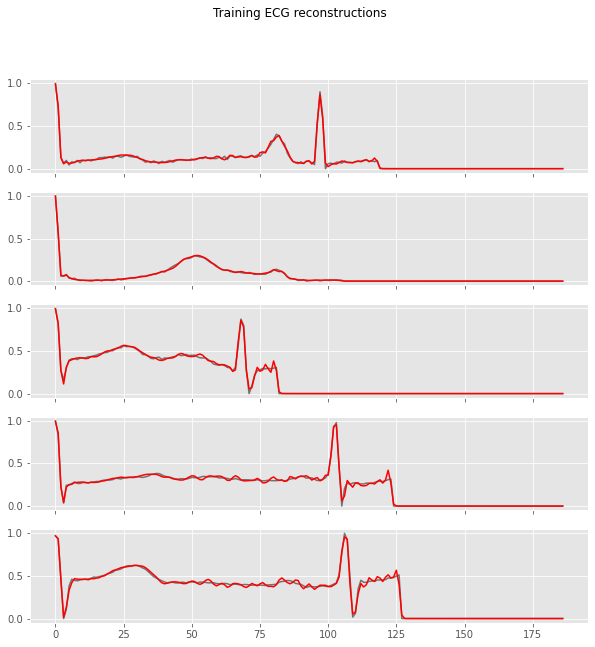

In [14]:
train_sample = random.sample(range(trainX.shape[0]), 5)

visualize_predictions(train_preds[train_sample,:], trainX[train_sample,:], title='Training ECG reconstructions')

#### Generate reconstructions for anomaly data 

In [15]:
anom_preds = autoencoder.predict(anom)

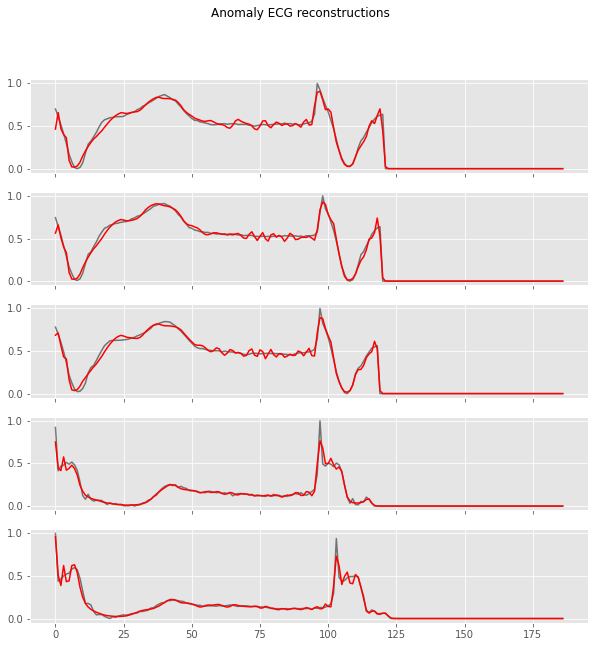

In [16]:
anom_sample = random.sample(range(anom.shape[0]), 5)

visualize_predictions(anom_preds[anom_sample,:], anom[anom_sample,:], title='Anomaly ECG reconstructions')

#### Compute mean reconstruction error for normal data

I have tried various methods to compute the reconstruction error - they all give pretty much the same answers
but some are faster to compute

In [17]:
train_errors = []
# loop over all originals and reconstructions
for (orig, recon) in zip(trainX, train_preds):
    # compute the mean squared error betweeen the truth and the
    # reconstruction and add it to a list of errors
    #mse = np.mean((orig - recon) ** 2)
    #x = np.tile(orig, (orig.size, 1))
    #y = np.transpose(np.tile(recon, (recon.size, 1)))
    #mean_diff = np.sum(np.abs(x-y)) / (orig.size * recon.size)
    #print(1.0 - np.mean(np.corrcoef(orig,recon, rowvar=False)))
    train_errors.append((1.0 - np.mean(np.corrcoef(orig,recon, rowvar=False))))
    #train_errors.append(mean_diff)

#### Compute 95% quantile

In [18]:
thresh = np.quantile(train_errors, 0.95)
print(thresh)

0.008530468059706114


#### Investigate potential anomalies

In [19]:
idxs = np.where(np.array(train_errors) >= thresh)[0]
print('Training data: {} out of {} are anomalies, or {}%'.format(len(idxs), len(trainX), (len(idxs)/len(trainX))*100.0))

Training data: 2899 out of 57976 are anomalies, or 5.000344970332551%


In [20]:
anom_errors = []
# loop over all originals and reconstructions
for (orig, recon) in zip(anom, anom_preds):
    # compute the mean squared error between the ground-truth image
    # and the reconstructed image, then add it to our list of errors
    #mse = np.mean((orig - recon) ** 2)
    #anom_errors.append(mse)
    anom_errors.append((1.0 - np.mean(np.corrcoef(orig,recon, rowvar=False))))

In [21]:
idxs = np.where(np.array(anom_errors) >= thresh)[0]
print('Anom data: {} out of {} are anomalies, or {}%'.format(len(idxs), len(anom), (len(idxs)/len(anom))*100.0))

Anom data: 986 out of 6431 are anomalies, or 15.331985694293268%


**The anomalous cases are reconstructed quite well, even though they were not used for training! So we do not get a clear detection of anomalies by using the reconstruction error.**

#### Examine what is happening in the latent space!

In [22]:
# We can create a new model that just comprises the encoder part by selecting layers from the original model 

encoder = tf.keras.Model(inputs=autoencoder.input,
                outputs=autoencoder.get_layer("encoded").output)

In [23]:
print(encoder.summary())

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 187, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 187, 32)           128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 94, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 94, 16)            1552      
_________________________________________________________________
flatten (Flatten)            (None, 1504)              0         
_________________________________________________________________
encoded (Dense)              (None, 50)                75250     
Total params: 76,930
Trainable params: 76,930
Non-trainable params: 0
__________________________________________________

#### Pass through the normal data

In [24]:
normal_encoded = encoder.predict(trainX)
print(normal_encoded.shape)

(57976, 50)


#### Pass through the anomaly data

In [25]:
anom_encoded = encoder.predict(anom)
print(anom_encoded.shape)
print(anom_encoded[0,:])

(6431, 50)
[-0.1299179   0.13140786  0.15917392 -0.04222212 -0.5010748   0.22870792
  0.13539848  0.23973846  0.16861911 -0.09488989  0.04052619  0.09606607
  0.45003867  0.13536417 -0.05254127  0.01902812  0.3943286  -0.36356393
  0.66032904  0.03354622  0.23769315  0.344803   -0.20464124 -0.12045412
  0.06457016 -0.05699286 -0.67233425  0.10358108  0.17800058 -0.03052666
  0.12035818  0.22863233  0.21915153  0.15917751 -0.5765515   0.09833705
 -0.11698416 -0.08422314  0.12608977 -0.4557274   0.13135606 -0.19769913
  0.10225782  0.10305268 -0.23231451  0.15630472 -0.01715869  0.07261297
 -0.01968287  0.9683342 ]


#### Prepare the data to visualise in Tensorflow Embedding Projector

In [26]:
out_v = io.open('./ae_vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('./ae_meta.tsv', 'w', encoding='utf-8')

for i in range(0,5000):
    vec = normal_encoded[i]
    out_m.write('normal\n')
    out_v.write('\t'.join([str(x) for x in vec]) + '\n')
    
for i in range(0,5000):
    vec = anom_encoded[i]
    out_m.write('anomaly\n')
    out_v.write('\t'.join([str(x) for x in vec]) + '\n')
    
out_v.close()
out_m.close()
